In [1]:
import matplotlib as mpl
from numpy import *
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import KFold, train_test_split, cross_val_score, StratifiedKFold
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, optimizers
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
def One_hot_raw(path):
    seqs = open(path).readlines()

    X1 = [seq.split()[1] for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[0]) for seq in seqs if seq.strip() != '']
    One = []
    for i in range(0, len(X1)):
        One.append(list(X1[i]))
    X = pd.DataFrame(One)
    return np.array(X), np.array(y)


def one_hot(rawDataFrame, codingMode=0):  # rawDataFrame is numpy.ndarray

    sampleSeq3DArr = rawDataFrame[:, :]

    if codingMode == 0:
        probMatr = convertSampleToProbMatr(sampleSeq3DArr)

    return probMatr


def convertSampleToProbMatr(sampleSeq3DArr):  # changed add one column for '1'

    letterDict = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4, "G": 5, "H": 6, "I": 7, "K": 8, "L": 9, "M": 10, "N": 11,
                  "P": 12, "Q": 13, "R": 14, "S": 15, "T": 16, "V": 17, "W": 18, "Y": 19, "X": 20}
    AACategoryLen = 21  # add -

    probMatr = np.zeros((len(sampleSeq3DArr), 1, len(sampleSeq3DArr[0]), AACategoryLen))

    sampleNo = 0
    for sequence in sampleSeq3DArr:

        AANo = 0
        for AA in sequence:

            if not AA in letterDict:
                probMatr[sampleNo][0][AANo] = np.full((1, AACategoryLen), 1.0 / AACategoryLen)

            else:
                index = letterDict[AA]
                probMatr[sampleNo][0][AANo][index] = 1

            AANo += 1
        sampleNo += 1

    return probMatr

In [4]:
def build_network():
    # 先创建包含多网络层的列表
    conv_layers = [
        layers.Conv1D(filters=128, kernel_size=1, padding='same', activation=tf.nn.relu),
        layers.Dropout(0.5),
        layers.MaxPooling1D(2),
        layers.Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu),
        layers.Dropout(0.5),
        layers.MaxPooling1D(2),
        layers.Conv1D(filters=128, kernel_size=9, padding='same', activation=tf.nn.relu),
        layers.MaxPooling1D(2),
        layers.Dropout(0.5)
    ]

    fc_layers = [
        layers.Dense(64, activation=tf.nn.relu),  # 全连接层， 64 个节点
        layers.GlobalAveragePooling1D(),
        layers.Dense(1, activation=tf.nn.sigmoid)  # 全连接层， 1 个节点
    ]

    conv_layers.extend(fc_layers)
    network = Sequential(conv_layers)
    network.build(input_shape=[None, 41, 21])#[None, 41, 21]
    base_learning_rate = 0.001
    network.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy',metrics=['accuracy'])#编译模型
    #network.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    network.summary()
    return network

In [5]:
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

In [6]:
batch_size=256

In [7]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\不自然数据\1正2345负')
epochs = 300
x_train,y_train = One_hot_raw('train.txt')#十折交叉验证10
x_test,y_test = One_hot_raw('test.txt')#独立测试1

In [8]:
x_train.shape

(2248, 41)

In [9]:
classes = sorted(list(set(y_train)))
x_train = one_hot(x_train)
x_test = one_hot(x_test)
x_train.shape = (x_train.shape[0],x_train.shape[2],x_train.shape[3])
x_test.shape = (x_test.shape[0],x_test.shape[2],x_test.shape[3])

In [10]:
x_train.shape

(2248, 41, 21)

In [11]:
# 构建独立测试集对象，预处理，批量化
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.map(preprocess).batch(batch_size)

In [12]:
prediction_result_cv = []
prediction_result_ind = []

In [13]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据')

In [14]:
out = os.getcwd() + '\\'

In [15]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    # 构建训练集对象，随机打乱，预处理，批量化
    train_db = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
    train_db = train_db.shuffle(len(tr_x)).map(preprocess).batch(batch_size)
    # 构建测试集对象，预处理，批量化
    valid_db = tf.data.Dataset.from_tensor_slices((val_x, val_y))
    valid_db = valid_db.map(preprocess).batch(batch_size)
    network = build_network()
    #if not os.path.exists('%s_%d.h5' % (out, n_fold)):
    best_saving = tf.keras.callbacks.ModelCheckpoint(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = network.fit(train_db, epochs=epochs, validation_data=valid_db, verbose=2,callbacks=[best_saving, early_stopping], batch_size=batch_size)
    #network.load_weights('%s_%d.h5' % (out, n_fold))
    #history = network.fit(train_db, epochs=50, validation_data=valid_db, verbose=2)
    scores1 = network.predict(val_x, batch_size=batch_size)[:, 0]
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1) 
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = network.predict(x_test, batch_size=batch_size)[:, 0]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 128)           1

8/8 - 0s - loss: 0.6475 - accuracy: 0.6223 - val_loss: 0.6738 - val_accuracy: 0.5956

Epoch 00031: val_loss did not improve from 0.67126
Epoch 32/300
8/8 - 0s - loss: 0.6355 - accuracy: 0.6367 - val_loss: 0.6710 - val_accuracy: 0.5911

Epoch 00032: val_loss improved from 0.67126 to 0.67102, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_0.h5
Epoch 33/300
8/8 - 0s - loss: 0.6572 - accuracy: 0.6085 - val_loss: 0.6751 - val_accuracy: 0.5822

Epoch 00033: val_loss did not improve from 0.67102
Epoch 34/300
8/8 - 0s - loss: 0.6407 - accuracy: 0.6401 - val_loss: 0.6713 - val_accuracy: 0.5956

Epoch 00034: val_loss did not improve from 0.67102
Epoch 35/300
8/8 - 0s - loss: 0.6533 - accuracy: 0.6194 - val_loss: 0.6781 - val_accuracy: 0.5556

Epoch 00035: val_loss did not improve from 0.67102
Epoch 36/300
8/8 - 0s - loss: 0.6465 - accuracy: 0.6179 - val_loss: 0.6728 - val_accuracy: 0.5867

Epoch 00036: val_loss did not improve from 0.67102
Ep

8/8 - 0s - loss: 0.5832 - accuracy: 0.6822 - val_loss: 0.6594 - val_accuracy: 0.5733

Epoch 00079: val_loss did not improve from 0.65537
Epoch 80/300
8/8 - 0s - loss: 0.5763 - accuracy: 0.6925 - val_loss: 0.6678 - val_accuracy: 0.5822

Epoch 00080: val_loss did not improve from 0.65537
Epoch 81/300
8/8 - 0s - loss: 0.5770 - accuracy: 0.6915 - val_loss: 0.6571 - val_accuracy: 0.5867

Epoch 00081: val_loss did not improve from 0.65537
Epoch 82/300
8/8 - 0s - loss: 0.5504 - accuracy: 0.7227 - val_loss: 0.6875 - val_accuracy: 0.5378

Epoch 00082: val_loss did not improve from 0.65537
Epoch 83/300
8/8 - 0s - loss: 0.5929 - accuracy: 0.6678 - val_loss: 0.6592 - val_accuracy: 0.6000

Epoch 00083: val_loss did not improve from 0.65537
Epoch 84/300
8/8 - 0s - loss: 0.5815 - accuracy: 0.6846 - val_loss: 0.6702 - val_accuracy: 0.5689

Epoch 00084: val_loss did not improve from 0.65537
Epoch 85/300
8/8 - 0s - loss: 0.5573 - accuracy: 0.7074 - val_loss: 0.7102 - val_accuracy: 0.5378

Epoch 00085: v


Epoch 00001: val_loss improved from inf to 0.69268, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_1.h5
Epoch 2/300
8/8 - 0s - loss: 0.6921 - accuracy: 0.5091 - val_loss: 0.6922 - val_accuracy: 0.5067

Epoch 00002: val_loss improved from 0.69268 to 0.69219, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_1.h5
Epoch 3/300
8/8 - 0s - loss: 0.6881 - accuracy: 0.5368 - val_loss: 0.6874 - val_accuracy: 0.6000

Epoch 00003: val_loss improved from 0.69219 to 0.68743, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_1.h5
Epoch 4/300
8/8 - 0s - loss: 0.6841 - accuracy: 0.5452 - val_loss: 0.6849 - val_accuracy: 0.5156

Epoch 00004: val_loss improved from 0.68743 to 0.68490, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_1.h5
Epoch 5/300
8/8 - 0s - loss: 0.6776 - accuracy: 0.5551 - val_

8/8 - 0s - loss: 0.6374 - accuracy: 0.6421 - val_loss: 0.6635 - val_accuracy: 0.6533

Epoch 00044: val_loss did not improve from 0.65500
Epoch 45/300
8/8 - 0s - loss: 0.6346 - accuracy: 0.6456 - val_loss: 0.6533 - val_accuracy: 0.6622

Epoch 00045: val_loss improved from 0.65500 to 0.65329, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_1.h5
Epoch 46/300
8/8 - 0s - loss: 0.6452 - accuracy: 0.6288 - val_loss: 0.6633 - val_accuracy: 0.6533

Epoch 00046: val_loss did not improve from 0.65329
Epoch 47/300
8/8 - 0s - loss: 0.6278 - accuracy: 0.6441 - val_loss: 0.6494 - val_accuracy: 0.6444

Epoch 00047: val_loss improved from 0.65329 to 0.64942, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_1.h5
Epoch 48/300
8/8 - 0s - loss: 0.6306 - accuracy: 0.6456 - val_loss: 0.6487 - val_accuracy: 0.6489

Epoch 00048: val_loss improved from 0.64942 to 0.64871, saving model to D:\PycharmProjects\p

8/8 - 0s - loss: 0.5704 - accuracy: 0.7059 - val_loss: 0.6296 - val_accuracy: 0.6711

Epoch 00090: val_loss improved from 0.63152 to 0.62957, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_1.h5
Epoch 91/300
8/8 - 0s - loss: 0.5745 - accuracy: 0.6886 - val_loss: 0.6370 - val_accuracy: 0.6800

Epoch 00091: val_loss did not improve from 0.62957
Epoch 92/300
8/8 - 0s - loss: 0.5462 - accuracy: 0.7252 - val_loss: 0.6408 - val_accuracy: 0.6267

Epoch 00092: val_loss did not improve from 0.62957
Epoch 93/300
8/8 - 0s - loss: 0.5672 - accuracy: 0.6940 - val_loss: 0.6310 - val_accuracy: 0.6889

Epoch 00093: val_loss did not improve from 0.62957
Epoch 94/300
8/8 - 0s - loss: 0.5561 - accuracy: 0.7143 - val_loss: 0.6308 - val_accuracy: 0.6756

Epoch 00094: val_loss did not improve from 0.62957
Epoch 95/300
8/8 - 0s - loss: 0.5658 - accuracy: 0.6990 - val_loss: 0.6349 - val_accuracy: 0.6844

Epoch 00095: val_loss did not improve from 0.62957
Ep

8/8 - 0s - loss: 0.4187 - accuracy: 0.8057 - val_loss: 0.6356 - val_accuracy: 0.6711

Epoch 00141: val_loss did not improve from 0.62367
Epoch 142/300
8/8 - 0s - loss: 0.4712 - accuracy: 0.7672 - val_loss: 0.6498 - val_accuracy: 0.6533

Epoch 00142: val_loss did not improve from 0.62367
Epoch 143/300
8/8 - 0s - loss: 0.4602 - accuracy: 0.7805 - val_loss: 0.6502 - val_accuracy: 0.6356

Epoch 00143: val_loss did not improve from 0.62367
Epoch 144/300
8/8 - 0s - loss: 0.4190 - accuracy: 0.8028 - val_loss: 0.6510 - val_accuracy: 0.6533

Epoch 00144: val_loss did not improve from 0.62367
Epoch 145/300
8/8 - 0s - loss: 0.4551 - accuracy: 0.7795 - val_loss: 0.6433 - val_accuracy: 0.6667

Epoch 00145: val_loss did not improve from 0.62367
Epoch 146/300
8/8 - 0s - loss: 0.4091 - accuracy: 0.8107 - val_loss: 0.6450 - val_accuracy: 0.6889

Epoch 00146: val_loss did not improve from 0.62367
Epoch 147/300
8/8 - 0s - loss: 0.4529 - accuracy: 0.7776 - val_loss: 0.6432 - val_accuracy: 0.6756

Epoch 00

8/8 - 0s - loss: 0.6798 - accuracy: 0.5615 - val_loss: 0.6788 - val_accuracy: 0.5378

Epoch 00006: val_loss improved from 0.68853 to 0.67884, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_2.h5
Epoch 7/300
8/8 - 0s - loss: 0.6772 - accuracy: 0.5596 - val_loss: 0.6749 - val_accuracy: 0.6400

Epoch 00007: val_loss improved from 0.67884 to 0.67492, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_2.h5
Epoch 8/300
8/8 - 0s - loss: 0.6793 - accuracy: 0.5660 - val_loss: 0.6796 - val_accuracy: 0.5556

Epoch 00008: val_loss did not improve from 0.67492
Epoch 9/300
8/8 - 0s - loss: 0.6717 - accuracy: 0.5808 - val_loss: 0.6748 - val_accuracy: 0.5600

Epoch 00009: val_loss improved from 0.67492 to 0.67484, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_2.h5
Epoch 10/300
8/8 - 0s - loss: 0.6715 - accuracy: 0.5912 - val_loss: 0.6707 - val_ac

8/8 - 0s - loss: 0.6219 - accuracy: 0.6436 - val_loss: 0.6723 - val_accuracy: 0.5600

Epoch 00052: val_loss did not improve from 0.64197
Epoch 53/300
8/8 - 0s - loss: 0.6319 - accuracy: 0.6372 - val_loss: 0.6559 - val_accuracy: 0.6489

Epoch 00053: val_loss did not improve from 0.64197
Epoch 54/300
8/8 - 0s - loss: 0.6330 - accuracy: 0.6436 - val_loss: 0.6473 - val_accuracy: 0.6533

Epoch 00054: val_loss did not improve from 0.64197
Epoch 55/300
8/8 - 0s - loss: 0.6250 - accuracy: 0.6416 - val_loss: 0.6450 - val_accuracy: 0.6844

Epoch 00055: val_loss did not improve from 0.64197
Epoch 56/300
8/8 - 0s - loss: 0.6285 - accuracy: 0.6500 - val_loss: 0.6439 - val_accuracy: 0.6489

Epoch 00056: val_loss did not improve from 0.64197
Epoch 57/300
8/8 - 0s - loss: 0.6098 - accuracy: 0.6500 - val_loss: 0.6395 - val_accuracy: 0.6400

Epoch 00057: val_loss improved from 0.64197 to 0.63953, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_2.h5
Ep

8/8 - 0s - loss: 0.5301 - accuracy: 0.7232 - val_loss: 0.6237 - val_accuracy: 0.6489

Epoch 00101: val_loss did not improve from 0.61964
Epoch 102/300
8/8 - 0s - loss: 0.5564 - accuracy: 0.6960 - val_loss: 0.6354 - val_accuracy: 0.6356

Epoch 00102: val_loss did not improve from 0.61964
Epoch 103/300
8/8 - 0s - loss: 0.5353 - accuracy: 0.7306 - val_loss: 0.6866 - val_accuracy: 0.5600

Epoch 00103: val_loss did not improve from 0.61964
Epoch 104/300
8/8 - 0s - loss: 0.5576 - accuracy: 0.6995 - val_loss: 0.6451 - val_accuracy: 0.6089

Epoch 00104: val_loss did not improve from 0.61964
Epoch 105/300
8/8 - 0s - loss: 0.5505 - accuracy: 0.7158 - val_loss: 0.6211 - val_accuracy: 0.6622

Epoch 00105: val_loss did not improve from 0.61964
Epoch 106/300
8/8 - 0s - loss: 0.5316 - accuracy: 0.7173 - val_loss: 0.6231 - val_accuracy: 0.6489

Epoch 00106: val_loss did not improve from 0.61964
Epoch 107/300
8/8 - 0s - loss: 0.5367 - accuracy: 0.7197 - val_loss: 0.6442 - val_accuracy: 0.6444

Epoch 00


Epoch 00152: val_loss did not improve from 0.60547
Epoch 153/300
8/8 - 0s - loss: 0.4353 - accuracy: 0.7860 - val_loss: 0.6181 - val_accuracy: 0.6667

Epoch 00153: val_loss did not improve from 0.60547
Epoch 154/300
8/8 - 0s - loss: 0.4015 - accuracy: 0.8151 - val_loss: 0.6115 - val_accuracy: 0.6933

Epoch 00154: val_loss did not improve from 0.60547
Epoch 155/300
8/8 - 0s - loss: 0.4265 - accuracy: 0.7899 - val_loss: 0.6103 - val_accuracy: 0.6978

Epoch 00155: val_loss did not improve from 0.60547
Epoch 156/300
8/8 - 0s - loss: 0.4330 - accuracy: 0.7973 - val_loss: 0.6246 - val_accuracy: 0.6533

Epoch 00156: val_loss did not improve from 0.60547
Epoch 157/300
8/8 - 0s - loss: 0.4363 - accuracy: 0.7939 - val_loss: 0.6209 - val_accuracy: 0.6711

Epoch 00157: val_loss did not improve from 0.60547
Epoch 158/300
8/8 - 0s - loss: 0.3899 - accuracy: 0.8265 - val_loss: 0.7053 - val_accuracy: 0.5911

Epoch 00158: val_loss did not improve from 0.60547
Epoch 159/300
8/8 - 0s - loss: 0.4300 - ac

8/8 - 0s - loss: 0.6730 - accuracy: 0.5828 - val_loss: 0.6720 - val_accuracy: 0.6356

Epoch 00009: val_loss improved from 0.67460 to 0.67200, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_3.h5
Epoch 10/300
8/8 - 0s - loss: 0.6744 - accuracy: 0.5734 - val_loss: 0.6717 - val_accuracy: 0.5822

Epoch 00010: val_loss improved from 0.67200 to 0.67170, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_3.h5
Epoch 11/300
8/8 - 0s - loss: 0.6688 - accuracy: 0.5808 - val_loss: 0.6707 - val_accuracy: 0.5778

Epoch 00011: val_loss improved from 0.67170 to 0.67066, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_3.h5
Epoch 12/300
8/8 - 0s - loss: 0.6715 - accuracy: 0.5813 - val_loss: 0.6744 - val_accuracy: 0.5778

Epoch 00012: val_loss did not improve from 0.67066
Epoch 13/300
8/8 - 0s - loss: 0.6597 - accuracy: 0.5917 - val_loss: 0.6621 - val

8/8 - 0s - loss: 0.6244 - accuracy: 0.6431 - val_loss: 0.6503 - val_accuracy: 0.6178

Epoch 00055: val_loss did not improve from 0.64336
Epoch 56/300
8/8 - 0s - loss: 0.6261 - accuracy: 0.6421 - val_loss: 0.6460 - val_accuracy: 0.6267

Epoch 00056: val_loss did not improve from 0.64336
Epoch 57/300
8/8 - 0s - loss: 0.6246 - accuracy: 0.6540 - val_loss: 0.6436 - val_accuracy: 0.6400

Epoch 00057: val_loss did not improve from 0.64336
Epoch 58/300
8/8 - 0s - loss: 0.6252 - accuracy: 0.6456 - val_loss: 0.6504 - val_accuracy: 0.6267

Epoch 00058: val_loss did not improve from 0.64336
Epoch 59/300
8/8 - 0s - loss: 0.6196 - accuracy: 0.6693 - val_loss: 0.6468 - val_accuracy: 0.6044

Epoch 00059: val_loss did not improve from 0.64336
Epoch 60/300
8/8 - 0s - loss: 0.6198 - accuracy: 0.6510 - val_loss: 0.6502 - val_accuracy: 0.6044

Epoch 00060: val_loss did not improve from 0.64336
Epoch 61/300
8/8 - 0s - loss: 0.6164 - accuracy: 0.6555 - val_loss: 0.6399 - val_accuracy: 0.6400

Epoch 00061: v


Epoch 00107: val_loss did not improve from 0.63807
Epoch 108/300
8/8 - 0s - loss: 0.5158 - accuracy: 0.7410 - val_loss: 0.6842 - val_accuracy: 0.5822

Epoch 00108: val_loss did not improve from 0.63807
Epoch 109/300
8/8 - 0s - loss: 0.5143 - accuracy: 0.7563 - val_loss: 0.6989 - val_accuracy: 0.5867

Epoch 00109: val_loss did not improve from 0.63807
Epoch 110/300
8/8 - 0s - loss: 0.5171 - accuracy: 0.7360 - val_loss: 0.6847 - val_accuracy: 0.6000

Epoch 00110: val_loss did not improve from 0.63807
Epoch 111/300
8/8 - 0s - loss: 0.5278 - accuracy: 0.7311 - val_loss: 0.6694 - val_accuracy: 0.5867

Epoch 00111: val_loss did not improve from 0.63807
Epoch 112/300
8/8 - 0s - loss: 0.5099 - accuracy: 0.7444 - val_loss: 0.6604 - val_accuracy: 0.5689

Epoch 00112: val_loss did not improve from 0.63807
Epoch 113/300
8/8 - 0s - loss: 0.5137 - accuracy: 0.7499 - val_loss: 0.6638 - val_accuracy: 0.5956

Epoch 00113: val_loss did not improve from 0.63807
Epoch 114/300
8/8 - 0s - loss: 0.4853 - ac


Epoch 00014: val_loss did not improve from 0.66296
Epoch 15/300
8/8 - 0s - loss: 0.6623 - accuracy: 0.5957 - val_loss: 0.6644 - val_accuracy: 0.6000

Epoch 00015: val_loss did not improve from 0.66296
Epoch 16/300
8/8 - 0s - loss: 0.6666 - accuracy: 0.5897 - val_loss: 0.6641 - val_accuracy: 0.6267

Epoch 00016: val_loss did not improve from 0.66296
Epoch 17/300
8/8 - 0s - loss: 0.6559 - accuracy: 0.6130 - val_loss: 0.6607 - val_accuracy: 0.6222

Epoch 00017: val_loss improved from 0.66296 to 0.66072, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_4.h5
Epoch 18/300
8/8 - 0s - loss: 0.6656 - accuracy: 0.5981 - val_loss: 0.6649 - val_accuracy: 0.6089

Epoch 00018: val_loss did not improve from 0.66072
Epoch 19/300
8/8 - 0s - loss: 0.6520 - accuracy: 0.6228 - val_loss: 0.6571 - val_accuracy: 0.6089

Epoch 00019: val_loss improved from 0.66072 to 0.65713, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amod


Epoch 00065: val_loss did not improve from 0.65136
Epoch 66/300
8/8 - 0s - loss: 0.6078 - accuracy: 0.6560 - val_loss: 0.6653 - val_accuracy: 0.5733

Epoch 00066: val_loss did not improve from 0.65136
Epoch 67/300
8/8 - 0s - loss: 0.6001 - accuracy: 0.6718 - val_loss: 0.6491 - val_accuracy: 0.5956

Epoch 00067: val_loss improved from 0.65136 to 0.64910, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_4.h5
Epoch 68/300
8/8 - 0s - loss: 0.5947 - accuracy: 0.6797 - val_loss: 0.6573 - val_accuracy: 0.5867

Epoch 00068: val_loss did not improve from 0.64910
Epoch 69/300
8/8 - 0s - loss: 0.6022 - accuracy: 0.6688 - val_loss: 0.6633 - val_accuracy: 0.6133

Epoch 00069: val_loss did not improve from 0.64910
Epoch 70/300
8/8 - 0s - loss: 0.5955 - accuracy: 0.6802 - val_loss: 0.6476 - val_accuracy: 0.5867

Epoch 00070: val_loss improved from 0.64910 to 0.64762, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amod


Epoch 00116: val_loss did not improve from 0.64381
Epoch 117/300
8/8 - 0s - loss: 0.5104 - accuracy: 0.7430 - val_loss: 0.6718 - val_accuracy: 0.5556

Epoch 00117: val_loss did not improve from 0.64381
Epoch 118/300
8/8 - 0s - loss: 0.4867 - accuracy: 0.7632 - val_loss: 0.6535 - val_accuracy: 0.6267

Epoch 00118: val_loss did not improve from 0.64381
Epoch 119/300
8/8 - 0s - loss: 0.4825 - accuracy: 0.7617 - val_loss: 0.6761 - val_accuracy: 0.5822

Epoch 00119: val_loss did not improve from 0.64381
Epoch 120/300
8/8 - 0s - loss: 0.4985 - accuracy: 0.7612 - val_loss: 0.6523 - val_accuracy: 0.6178

Epoch 00120: val_loss did not improve from 0.64381
Epoch 121/300
8/8 - 0s - loss: 0.5169 - accuracy: 0.7454 - val_loss: 0.6592 - val_accuracy: 0.5956

Epoch 00121: val_loss did not improve from 0.64381
Epoch 122/300
8/8 - 0s - loss: 0.4701 - accuracy: 0.7776 - val_loss: 0.6535 - val_accuracy: 0.6133

Epoch 00122: val_loss did not improve from 0.64381
Epoch 123/300
8/8 - 0s - loss: 0.4942 - ac

8/8 - 0s - loss: 0.6911 - accuracy: 0.5200 - val_loss: 0.6910 - val_accuracy: 0.5644

Epoch 00003: val_loss improved from 0.69245 to 0.69095, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_5.h5
Epoch 4/300
8/8 - 0s - loss: 0.6865 - accuracy: 0.5348 - val_loss: 0.6918 - val_accuracy: 0.5156

Epoch 00004: val_loss did not improve from 0.69095
Epoch 5/300
8/8 - 0s - loss: 0.6848 - accuracy: 0.5472 - val_loss: 0.6871 - val_accuracy: 0.5778

Epoch 00005: val_loss improved from 0.69095 to 0.68709, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_5.h5
Epoch 6/300
8/8 - 0s - loss: 0.6750 - accuracy: 0.5685 - val_loss: 0.6854 - val_accuracy: 0.5733

Epoch 00006: val_loss improved from 0.68709 to 0.68538, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_5.h5
Epoch 7/300
8/8 - 0s - loss: 0.6819 - accuracy: 0.5517 - val_loss: 0.6877 - val_acc

8/8 - 0s - loss: 0.6325 - accuracy: 0.6426 - val_loss: 0.6717 - val_accuracy: 0.5867

Epoch 00044: val_loss did not improve from 0.66652
Epoch 45/300
8/8 - 0s - loss: 0.6282 - accuracy: 0.6347 - val_loss: 0.6745 - val_accuracy: 0.5689

Epoch 00045: val_loss did not improve from 0.66652
Epoch 46/300
8/8 - 0s - loss: 0.6225 - accuracy: 0.6530 - val_loss: 0.6649 - val_accuracy: 0.5911

Epoch 00046: val_loss improved from 0.66652 to 0.66494, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_5.h5
Epoch 47/300
8/8 - 0s - loss: 0.6414 - accuracy: 0.6342 - val_loss: 0.6675 - val_accuracy: 0.5733

Epoch 00047: val_loss did not improve from 0.66494
Epoch 48/300
8/8 - 0s - loss: 0.6302 - accuracy: 0.6490 - val_loss: 0.6724 - val_accuracy: 0.5689

Epoch 00048: val_loss did not improve from 0.66494
Epoch 49/300
8/8 - 0s - loss: 0.6288 - accuracy: 0.6461 - val_loss: 0.6641 - val_accuracy: 0.5689

Epoch 00049: val_loss improved from 0.66494 to 0.6640


Epoch 00088: val_loss did not improve from 0.64089
Epoch 89/300
8/8 - 0s - loss: 0.5557 - accuracy: 0.7128 - val_loss: 0.6491 - val_accuracy: 0.6311

Epoch 00089: val_loss did not improve from 0.64089
Epoch 90/300
8/8 - 0s - loss: 0.5639 - accuracy: 0.6915 - val_loss: 0.6448 - val_accuracy: 0.6178

Epoch 00090: val_loss did not improve from 0.64089
Epoch 91/300
8/8 - 0s - loss: 0.5580 - accuracy: 0.7128 - val_loss: 0.6446 - val_accuracy: 0.6311

Epoch 00091: val_loss did not improve from 0.64089
Epoch 92/300
8/8 - 0s - loss: 0.5514 - accuracy: 0.7202 - val_loss: 0.6436 - val_accuracy: 0.6489

Epoch 00092: val_loss did not improve from 0.64089
Epoch 93/300
8/8 - 0s - loss: 0.5478 - accuracy: 0.7148 - val_loss: 0.6451 - val_accuracy: 0.6400

Epoch 00093: val_loss did not improve from 0.64089
Epoch 94/300
8/8 - 0s - loss: 0.5841 - accuracy: 0.6925 - val_loss: 0.6470 - val_accuracy: 0.6222

Epoch 00094: val_loss did not improve from 0.64089
Epoch 95/300
8/8 - 0s - loss: 0.5297 - accuracy:


Epoch 00142: val_loss did not improve from 0.64013
Epoch 143/300
8/8 - 0s - loss: 0.4677 - accuracy: 0.7652 - val_loss: 0.6686 - val_accuracy: 0.6222

Epoch 00143: val_loss did not improve from 0.64013
Epoch 144/300
8/8 - 0s - loss: 0.3986 - accuracy: 0.8201 - val_loss: 0.6847 - val_accuracy: 0.6444

Epoch 00144: val_loss did not improve from 0.64013
Epoch 145/300
8/8 - 0s - loss: 0.3986 - accuracy: 0.8191 - val_loss: 0.8099 - val_accuracy: 0.5822

Epoch 00145: val_loss did not improve from 0.64013
Epoch 146/300
8/8 - 0s - loss: 0.4661 - accuracy: 0.7810 - val_loss: 0.6855 - val_accuracy: 0.6267

Epoch 00146: val_loss did not improve from 0.64013
6
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 41, 128)           2816      
_________________________________________________________________
dropout_18 (Dropout)         (None, 41, 128)           0

8/8 - 0s - loss: 0.6458 - accuracy: 0.6263 - val_loss: 0.6627 - val_accuracy: 0.6044

Epoch 00024: val_loss improved from 0.66395 to 0.66269, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_6.h5
Epoch 25/300
8/8 - 0s - loss: 0.6678 - accuracy: 0.6110 - val_loss: 0.6701 - val_accuracy: 0.6222

Epoch 00025: val_loss did not improve from 0.66269
Epoch 26/300
8/8 - 0s - loss: 0.6484 - accuracy: 0.6223 - val_loss: 0.6624 - val_accuracy: 0.6311

Epoch 00026: val_loss improved from 0.66269 to 0.66236, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_6.h5
Epoch 27/300
8/8 - 0s - loss: 0.6545 - accuracy: 0.6041 - val_loss: 0.6649 - val_accuracy: 0.6267

Epoch 00027: val_loss did not improve from 0.66236
Epoch 28/300
8/8 - 0s - loss: 0.6470 - accuracy: 0.6273 - val_loss: 0.6686 - val_accuracy: 0.5733

Epoch 00028: val_loss did not improve from 0.66236
Epoch 29/300
8/8 - 0s - loss: 0.6455 - ac

8/8 - 0s - loss: 0.5907 - accuracy: 0.6876 - val_loss: 0.6681 - val_accuracy: 0.5778

Epoch 00072: val_loss did not improve from 0.65061
Epoch 73/300
8/8 - 0s - loss: 0.5806 - accuracy: 0.7064 - val_loss: 0.6556 - val_accuracy: 0.6356

Epoch 00073: val_loss did not improve from 0.65061
Epoch 74/300
8/8 - 0s - loss: 0.5877 - accuracy: 0.6698 - val_loss: 0.6667 - val_accuracy: 0.5733

Epoch 00074: val_loss did not improve from 0.65061
Epoch 75/300
8/8 - 0s - loss: 0.6010 - accuracy: 0.6886 - val_loss: 0.6721 - val_accuracy: 0.5644

Epoch 00075: val_loss did not improve from 0.65061
Epoch 76/300
8/8 - 0s - loss: 0.5882 - accuracy: 0.6817 - val_loss: 0.6590 - val_accuracy: 0.6400

Epoch 00076: val_loss did not improve from 0.65061
Epoch 77/300
8/8 - 0s - loss: 0.5939 - accuracy: 0.6752 - val_loss: 0.6513 - val_accuracy: 0.6133

Epoch 00077: val_loss did not improve from 0.65061
Epoch 78/300
8/8 - 0s - loss: 0.5971 - accuracy: 0.6698 - val_loss: 0.6645 - val_accuracy: 0.5822

Epoch 00078: v

8/8 - 1s - loss: 0.7165 - accuracy: 0.4844 - val_loss: 0.6928 - val_accuracy: 0.4889

Epoch 00001: val_loss improved from inf to 0.69280, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_7.h5
Epoch 2/300
8/8 - 0s - loss: 0.6927 - accuracy: 0.5106 - val_loss: 0.6921 - val_accuracy: 0.5067

Epoch 00002: val_loss improved from 0.69280 to 0.69214, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_7.h5
Epoch 3/300
8/8 - 0s - loss: 0.6897 - accuracy: 0.5334 - val_loss: 0.6898 - val_accuracy: 0.5911

Epoch 00003: val_loss improved from 0.69214 to 0.68978, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_7.h5
Epoch 4/300
8/8 - 0s - loss: 0.6894 - accuracy: 0.5437 - val_loss: 0.6892 - val_accuracy: 0.5289

Epoch 00004: val_loss improved from 0.68978 to 0.68918, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amod

8/8 - 0s - loss: 0.6429 - accuracy: 0.6194 - val_loss: 0.6688 - val_accuracy: 0.5600

Epoch 00044: val_loss did not improve from 0.64989
Epoch 45/300
8/8 - 0s - loss: 0.6410 - accuracy: 0.6214 - val_loss: 0.6553 - val_accuracy: 0.6133

Epoch 00045: val_loss did not improve from 0.64989
Epoch 46/300
8/8 - 0s - loss: 0.6351 - accuracy: 0.6416 - val_loss: 0.6512 - val_accuracy: 0.6178

Epoch 00046: val_loss did not improve from 0.64989
Epoch 47/300
8/8 - 0s - loss: 0.6336 - accuracy: 0.6426 - val_loss: 0.6668 - val_accuracy: 0.5733

Epoch 00047: val_loss did not improve from 0.64989
Epoch 48/300
8/8 - 0s - loss: 0.6250 - accuracy: 0.6436 - val_loss: 0.6454 - val_accuracy: 0.6133

Epoch 00048: val_loss improved from 0.64989 to 0.64543, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_7.h5
Epoch 49/300
8/8 - 0s - loss: 0.6302 - accuracy: 0.6372 - val_loss: 0.6487 - val_accuracy: 0.6178

Epoch 00049: val_loss did not improve from 0.64543
Ep

8/8 - 0s - loss: 0.5335 - accuracy: 0.7370 - val_loss: 0.6735 - val_accuracy: 0.5867

Epoch 00098: val_loss did not improve from 0.64543
8
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 41, 128)           2816      
_________________________________________________________________
dropout_24 (Dropout)         (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 20, 128)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 20, 128)           49280     
_________________________________________________________________
dropout_25 (Dropout)         (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 10, 128)   

8/8 - 0s - loss: 0.6503 - accuracy: 0.6077 - val_loss: 0.6546 - val_accuracy: 0.6071

Epoch 00028: val_loss did not improve from 0.64914
Epoch 29/300
8/8 - 0s - loss: 0.6570 - accuracy: 0.6072 - val_loss: 0.6572 - val_accuracy: 0.6786

Epoch 00029: val_loss did not improve from 0.64914
Epoch 30/300
8/8 - 0s - loss: 0.6477 - accuracy: 0.6260 - val_loss: 0.6524 - val_accuracy: 0.6116

Epoch 00030: val_loss did not improve from 0.64914
Epoch 31/300
8/8 - 0s - loss: 0.6463 - accuracy: 0.6235 - val_loss: 0.6535 - val_accuracy: 0.5893

Epoch 00031: val_loss did not improve from 0.64914
Epoch 32/300
8/8 - 0s - loss: 0.6510 - accuracy: 0.6255 - val_loss: 0.6549 - val_accuracy: 0.6339

Epoch 00032: val_loss did not improve from 0.64914
Epoch 33/300
8/8 - 0s - loss: 0.6499 - accuracy: 0.6225 - val_loss: 0.6504 - val_accuracy: 0.6830

Epoch 00033: val_loss did not improve from 0.64914
Epoch 34/300
8/8 - 0s - loss: 0.6449 - accuracy: 0.6319 - val_loss: 0.6489 - val_accuracy: 0.6562

Epoch 00034: v


Epoch 00078: val_loss did not improve from 0.63399
Epoch 79/300
8/8 - 0s - loss: 0.6037 - accuracy: 0.6739 - val_loss: 0.6497 - val_accuracy: 0.5848

Epoch 00079: val_loss did not improve from 0.63399
Epoch 80/300
8/8 - 0s - loss: 0.5858 - accuracy: 0.6981 - val_loss: 0.6531 - val_accuracy: 0.6116

Epoch 00080: val_loss did not improve from 0.63399
Epoch 81/300
8/8 - 0s - loss: 0.5759 - accuracy: 0.6927 - val_loss: 0.6637 - val_accuracy: 0.6205

Epoch 00081: val_loss did not improve from 0.63399
Epoch 82/300
8/8 - 0s - loss: 0.5797 - accuracy: 0.6947 - val_loss: 0.6286 - val_accuracy: 0.6518

Epoch 00082: val_loss improved from 0.63399 to 0.62858, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_8.h5
Epoch 83/300
8/8 - 0s - loss: 0.5547 - accuracy: 0.7149 - val_loss: 0.6374 - val_accuracy: 0.6295

Epoch 00083: val_loss did not improve from 0.62858
Epoch 84/300
8/8 - 0s - loss: 0.5768 - accuracy: 0.6877 - val_loss: 0.6703 - val_accura


Epoch 00131: val_loss did not improve from 0.62515
Epoch 132/300
8/8 - 0s - loss: 0.4295 - accuracy: 0.8053 - val_loss: 0.6577 - val_accuracy: 0.5938

Epoch 00132: val_loss did not improve from 0.62515
Epoch 133/300
8/8 - 0s - loss: 0.4702 - accuracy: 0.7668 - val_loss: 0.6640 - val_accuracy: 0.6116

Epoch 00133: val_loss did not improve from 0.62515
Epoch 134/300
8/8 - 0s - loss: 0.4527 - accuracy: 0.7826 - val_loss: 0.6710 - val_accuracy: 0.5893

Epoch 00134: val_loss did not improve from 0.62515
Epoch 135/300
8/8 - 0s - loss: 0.4240 - accuracy: 0.8093 - val_loss: 0.6593 - val_accuracy: 0.6116

Epoch 00135: val_loss did not improve from 0.62515
Epoch 136/300
8/8 - 0s - loss: 0.4488 - accuracy: 0.7836 - val_loss: 0.6408 - val_accuracy: 0.6652

Epoch 00136: val_loss did not improve from 0.62515
Epoch 137/300
8/8 - 0s - loss: 0.4362 - accuracy: 0.8004 - val_loss: 0.6460 - val_accuracy: 0.6295

Epoch 00137: val_loss did not improve from 0.62515
9
Model: "sequential_9"
__________________

8/8 - 0s - loss: 0.6543 - accuracy: 0.6265 - val_loss: 0.6412 - val_accuracy: 0.6295

Epoch 00024: val_loss did not improve from 0.64112
Epoch 25/300
8/8 - 0s - loss: 0.6541 - accuracy: 0.6156 - val_loss: 0.6379 - val_accuracy: 0.6384

Epoch 00025: val_loss improved from 0.64112 to 0.63790, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\_9.h5
Epoch 26/300
8/8 - 0s - loss: 0.6579 - accuracy: 0.6047 - val_loss: 0.6537 - val_accuracy: 0.5982

Epoch 00026: val_loss did not improve from 0.63790
Epoch 27/300
8/8 - 0s - loss: 0.6547 - accuracy: 0.6225 - val_loss: 0.6590 - val_accuracy: 0.5938

Epoch 00027: val_loss did not improve from 0.63790
Epoch 28/300
8/8 - 0s - loss: 0.6524 - accuracy: 0.6215 - val_loss: 0.6497 - val_accuracy: 0.5982

Epoch 00028: val_loss did not improve from 0.63790
Epoch 29/300
8/8 - 0s - loss: 0.6587 - accuracy: 0.6102 - val_loss: 0.6435 - val_accuracy: 0.6429

Epoch 00029: val_loss did not improve from 0.63790
Ep


Epoch 00074: val_loss did not improve from 0.61958
Epoch 75/300
8/8 - 0s - loss: 0.6101 - accuracy: 0.6537 - val_loss: 0.6342 - val_accuracy: 0.6339

Epoch 00075: val_loss did not improve from 0.61958
Epoch 76/300
8/8 - 0s - loss: 0.6018 - accuracy: 0.6759 - val_loss: 0.6279 - val_accuracy: 0.6429

Epoch 00076: val_loss did not improve from 0.61958
Epoch 77/300
8/8 - 0s - loss: 0.6009 - accuracy: 0.6798 - val_loss: 0.6319 - val_accuracy: 0.6473

Epoch 00077: val_loss did not improve from 0.61958
Epoch 78/300
8/8 - 0s - loss: 0.5889 - accuracy: 0.6976 - val_loss: 0.6318 - val_accuracy: 0.6339

Epoch 00078: val_loss did not improve from 0.61958
Epoch 79/300
8/8 - 0s - loss: 0.5875 - accuracy: 0.6902 - val_loss: 0.6552 - val_accuracy: 0.5938

Epoch 00079: val_loss did not improve from 0.61958
Epoch 80/300
8/8 - 0s - loss: 0.5881 - accuracy: 0.6947 - val_loss: 0.6382 - val_accuracy: 0.6250

Epoch 00080: val_loss did not improve from 0.61958
Epoch 81/300
8/8 - 0s - loss: 0.5892 - accuracy:

In [16]:
#遍历表格求初始里程
#交叉验证
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [17]:
roc_auc_list_val

[0.6361409608091024,
 0.632015306122449,
 0.682759165613148,
 0.7048830594184576,
 0.6343236409608092,
 0.6661662452591656,
 0.6571586599241467,
 0.6248419721871049,
 0.6609513274336283,
 0.6902104591836735]

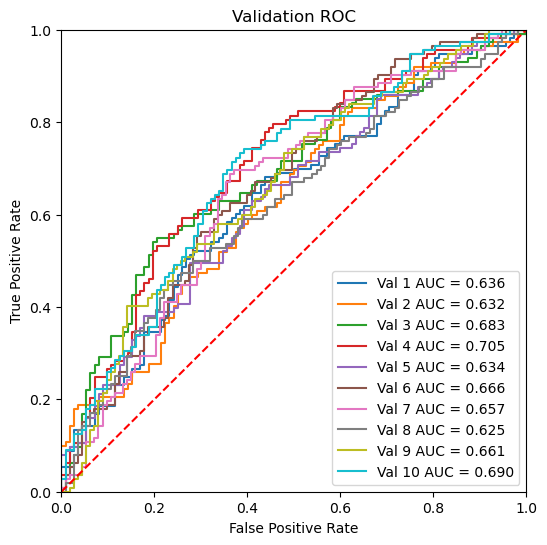

In [18]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_val.png')
plt.show()

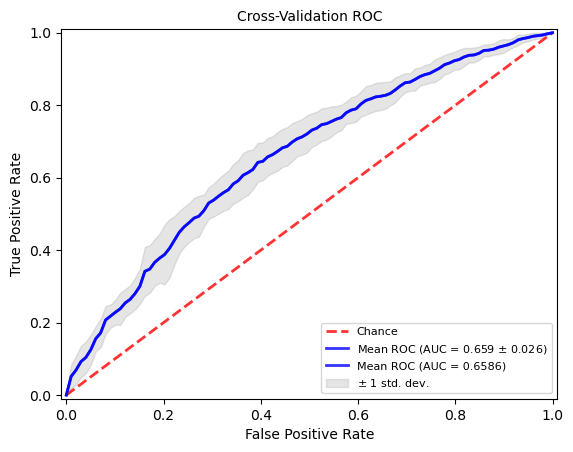

In [19]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_val_mean.png')
plt.show()

In [20]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [21]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)

In [22]:
my_calculate_metrics_list_val

[{'SN': 0.7433628318584071,
  'SP': 0.42857142857142855,
  'ACC': 0.5866666666666667,
  'MCC': 0.18119008872828224,
  'Recall': 0.7433628318584071,
  'Precision': 0.5675675675675675,
  'F1-score': 0.6436781609195402,
  'Cutoff': 0.5},
 {'SN': 0.875,
  'SP': 0.25892857142857145,
  'ACC': 0.5669642857142857,
  'MCC': 0.17002694195893026,
  'Recall': 0.875,
  'Precision': 0.5414364640883977,
  'F1-score': 0.6689419795221843,
  'Cutoff': 0.5},
 {'SN': 0.5575221238938053,
  'SP': 0.7589285714285714,
  'ACC': 0.6577777777777778,
  'MCC': 0.32297294855011277,
  'Recall': 0.5575221238938053,
  'Precision': 0.7,
  'F1-score': 0.6206896551724138,
  'Cutoff': 0.5},
 {'SN': 0.8672566371681416,
  'SP': 0.35714285714285715,
  'ACC': 0.6133333333333333,
  'MCC': 0.26107440778511043,
  'Recall': 0.8672566371681416,
  'Precision': 0.5764705882352941,
  'F1-score': 0.6925795053003534,
  'Cutoff': 0.5},
 {'SN': 0.7699115044247787,
  'SP': 0.36607142857142855,
  'ACC': 0.5688888888888889,
  'MCC': 0.14868

In [23]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.743363,0.428571,0.586667,0.181190,0.743363,0.567568,0.643678,0.5
1,0.875000,0.258929,0.566964,0.170027,0.875000,0.541436,0.668942,0.5
2,0.557522,0.758929,0.657778,0.322973,0.557522,0.700000,0.620690,0.5
3,0.867257,0.357143,0.613333,0.261074,0.867257,0.576471,0.692580,0.5
4,0.769912,0.366071,0.568889,0.148685,0.769912,0.550633,0.642066,0.5
5,0.589286,0.663717,0.626667,0.253725,0.589286,0.634615,0.611111,0.5
6,0.723214,0.530973,0.626667,0.258958,0.723214,0.604478,0.658537,0.5
7,0.455357,0.761062,0.608889,0.227372,0.455357,0.653846,0.536842,0.5
8,0.848214,0.327434,0.586667,0.205635,0.848214,0.555556,0.671378,0.5
9,0.544643,0.714286,0.629464,0.262737,0.544643,0.655914,0.595122,0.5


In [24]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.743363,0.428571,0.586667,0.181190,0.743363,0.567568,0.643678,0.5
1,0.875000,0.258929,0.566964,0.170027,0.875000,0.541436,0.668942,0.5
2,0.557522,0.758929,0.657778,0.322973,0.557522,0.700000,0.620690,0.5
3,0.867257,0.357143,0.613333,0.261074,0.867257,0.576471,0.692580,0.5
4,0.769912,0.366071,0.568889,0.148685,0.769912,0.550633,0.642066,0.5
5,0.589286,0.663717,0.626667,0.253725,0.589286,0.634615,0.611111,0.5
6,0.723214,0.530973,0.626667,0.258958,0.723214,0.604478,0.658537,0.5
7,0.455357,0.761062,0.608889,0.227372,0.455357,0.653846,0.536842,0.5
8,0.848214,0.327434,0.586667,0.205635,0.848214,0.555556,0.671378,0.5
9,0.544643,0.714286,0.629464,0.262737,0.544643,0.655914,0.595122,0.5


In [25]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\result\CNN_OH_performance_val.csv',encoding='utf-8')

独立测试

In [26]:
#遍历表格求初始里程
#独立测试
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [27]:
roc_auc_list_indep

[0.6712372448979592,
 0.6703603316326531,
 0.6391900510204083,
 0.6365593112244898,
 0.6129623724489796,
 0.6705197704081634,
 0.6107302295918366,
 0.6306600765306123,
 0.6655771683673469,
 0.6814413265306123]

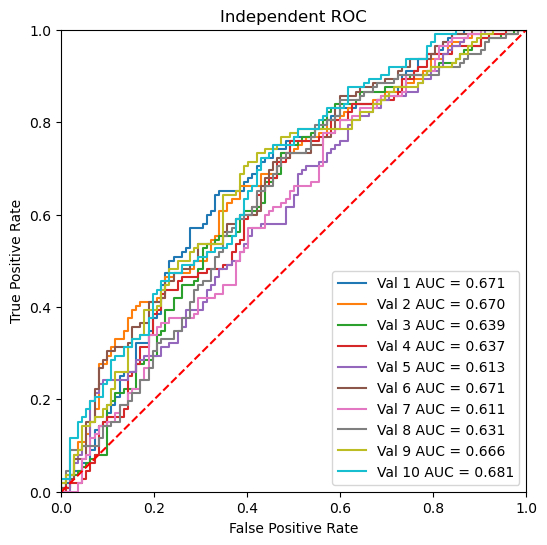

In [28]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_indep.png')
plt.show()

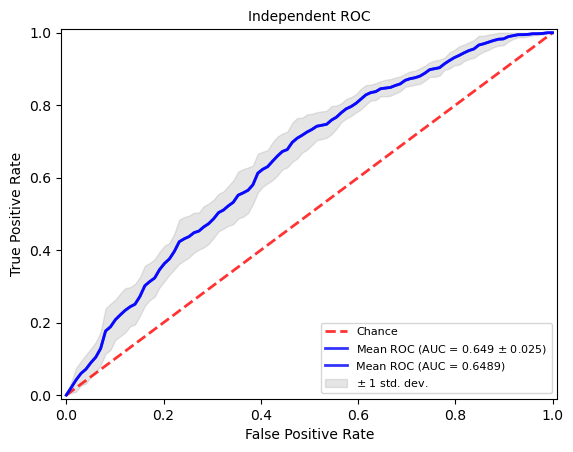

In [29]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_indep_mean.png')
plt.show()

In [30]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [31]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)

In [32]:
my_calculate_metrics_list_indep

[{'SN': 0.8303571428571429,
  'SP': 0.38392857142857145,
  'ACC': 0.6071428571428571,
  'MCC': 0.23947373603569988,
  'Recall': 0.8303571428571429,
  'Precision': 0.5740740740740741,
  'F1-score': 0.6788321167883211,
  'Cutoff': 0.5},
 {'SN': 0.8839285714285714,
  'SP': 0.25,
  'ACC': 0.5669642857142857,
  'MCC': 0.1731704501295783,
  'Recall': 0.8839285714285714,
  'Precision': 0.5409836065573771,
  'F1-score': 0.6711864406779661,
  'Cutoff': 0.5},
 {'SN': 0.41964285714285715,
  'SP': 0.7589285714285714,
  'ACC': 0.5892857142857143,
  'MCC': 0.1898315991504998,
  'Recall': 0.41964285714285715,
  'Precision': 0.6351351351351351,
  'F1-score': 0.5053763440860215,
  'Cutoff': 0.5},
 {'SN': 0.8928571428571429,
  'SP': 0.25892857142857145,
  'ACC': 0.5758928571428571,
  'MCC': 0.19625984348018874,
  'Recall': 0.8928571428571429,
  'Precision': 0.546448087431694,
  'F1-score': 0.6779661016949152,
  'Cutoff': 0.5},
 {'SN': 0.8035714285714286,
  'SP': 0.375,
  'ACC': 0.5892857142857143,
  'MC

In [33]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.830357,0.383929,0.607143,0.239474,0.830357,0.574074,0.678832,0.5
1,0.883929,0.250000,0.566964,0.173170,0.883929,0.540984,0.671186,0.5
2,0.419643,0.758929,0.589286,0.189832,0.419643,0.635135,0.505376,0.5
3,0.892857,0.258929,0.575893,0.196260,0.892857,0.546448,0.677966,0.5
4,0.803571,0.375000,0.589286,0.197642,0.803571,0.562500,0.661765,0.5
5,0.571429,0.642857,0.607143,0.214834,0.571429,0.615385,0.592593,0.5
6,0.803571,0.392857,0.598214,0.215438,0.803571,0.569620,0.666667,0.5
7,0.446429,0.705357,0.575893,0.157145,0.446429,0.602410,0.512821,0.5
8,0.821429,0.339286,0.580357,0.183444,0.821429,0.554217,0.661871,0.5
9,0.437500,0.794643,0.616071,0.248534,0.437500,0.680556,0.532609,0.5


In [34]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.830357,0.383929,0.607143,0.239474,0.830357,0.574074,0.678832,0.5
1,0.883929,0.250000,0.566964,0.173170,0.883929,0.540984,0.671186,0.5
2,0.419643,0.758929,0.589286,0.189832,0.419643,0.635135,0.505376,0.5
3,0.892857,0.258929,0.575893,0.196260,0.892857,0.546448,0.677966,0.5
4,0.803571,0.375000,0.589286,0.197642,0.803571,0.562500,0.661765,0.5
5,0.571429,0.642857,0.607143,0.214834,0.571429,0.615385,0.592593,0.5
6,0.803571,0.392857,0.598214,0.215438,0.803571,0.569620,0.666667,0.5
7,0.446429,0.705357,0.575893,0.157145,0.446429,0.602410,0.512821,0.5
8,0.821429,0.339286,0.580357,0.183444,0.821429,0.554217,0.661871,0.5
9,0.437500,0.794643,0.616071,0.248534,0.437500,0.680556,0.532609,0.5


In [35]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_OH_全K数据\result\CNN_OH_performance_indep.csv',encoding='utf-8')

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

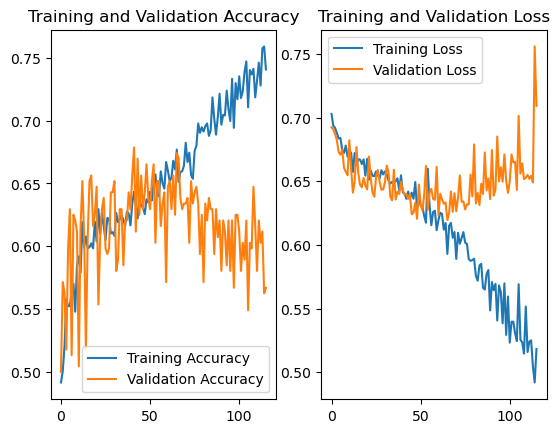

In [37]:
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()